In [1]:
import os
import numpy as np
import torch as tr

from glob import glob as glob
import pandas as pd

from CSWSEM import *

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('talk')

In [2]:
hdf = pd.read_csv('gsdata/humandf.csv')
humanB = hdf.loc[:,'blocked mean']
humanI = hdf.loc[:,'interleaved mean']

In [3]:
gsname = 'gs2'
lrL = [0.01, 0.05, 0.1]
alfaL = [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
lmdaL = [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

In [4]:
def make_gsdf(gsname,save=False,debug=False):
  gs_dir = "gsdata/%s/"%gsname
  fpathL = glob(gs_dir+'*')
  df_L = []
  ### initialize gsdf
  if debug: fpathL = fpathL[:20]
  for fpath in fpathL:
    batch_df = pd.read_csv(fpath)
    df_L.append(batch_df)
  gsdf = pd.concat(df_L)
  ### gsdf manipulations
  gsdf.index = np.arange(len(gsdf))
  gsdf = gsdf.drop(columns=['Unnamed: 0','like','prior'])
  gsdf.loc[:,'accuracy'] = 1-gsdf.loc[:,'loss']
  gsdf.loc[(gsdf.trial>=160),'phase'] = 'test'
  gsdf.loc[(gsdf.trial<160),'phase'] = 'train'
  gsdf.loc[:,'period'] = gsdf.trial%5
  if save:
    gsdf.to_csv('gsdata/%s.csv'%gsname)
    print('saved %s.csv'%gsname)
  return gsdf

In [115]:
gsdf = make_gsdf(gsname,save=0,debug=1)
# gsdf = make_gsdf(gsname,save=1,debug=0)
# gsdf = pd.read_csv('gsdata/%s.csv'%gsname)
print('max delta_time',gsdf.delta_time.max())

max delta_time 55.34397864341736


In [109]:
gsdf

,Unnamed: 0,trial,curriculum,active_schema,loss,nosplit,stsize,learn_rate,lmda,alfa,seed,condition,delta_time,accuracy,phase,period
0,0,0,0,0,0.575111,0,25,0.1,0.1,1000.0,0,blocked,16.475104,0.424889,train,0
1,1,1,0,1,0.661490,0,25,0.1,0.1,1000.0,0,blocked,16.475104,0.338510,train,1
2,2,2,0,2,0.575111,0,25,0.1,0.1,1000.0,0,blocked,16.475104,0.424889,train,2
3,3,3,0,3,0.575111,0,25,0.1,0.1,1000.0,0,blocked,16.475104,0.424889,train,3
4,4,4,0,4,0.497131,0,25,0.1,0.1,1000.0,0,blocked,16.475104,0.502869,train,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7833595,7833595,195,0,0,0.079244,1,25,0.1,100.0,100.0,50,interleaved,2.436420,0.920756,test,0
7833596,7833596,196,1,0,0.216044,1,25,0.1,100.0,100.0,50,interleaved,2.436420,0.783956,test,1
7833597,7833597,197,1,0,0.144499,1,25,0.1,100.0,100.0,50,interleaved,2.436420,0.855501,test,2
7833598,7833598,198,1,0,0.126838,1,25,0.1,100.0,100.0,50,interleaved,2.436420,0.873162,test,3


In [108]:
def build_dataD(gsdf,metric='accuracy',verb=True):
  """ 
  extracts and reformats a column of gsdf
  D[model+param_str][cond] = [seed,time]
  """
  paramL = ['learn_rate','alfa','lmda']
  dataD = {}
  for nosplit,m_df in gsdf.groupby(['nosplit']):  
    if nosplit: model='LSTM'
    else: model='SEM'
    for p,p_df in m_df.groupby(paramL):
      param_str = "-".join([str(p_i) for p_i in p])
      dataD_key = "%s-%s"%(model,param_str)
      dataD[dataD_key] = {}
      for cond,c_df in p_df.groupby('condition'):
        if verb: print(model,param_str,cond)
        sgroup = c_df.groupby('seed')
        seed_arr = -np.ones([len(sgroup),200])
        for s_idx,(s,s_df) in enumerate(sgroup):
          seed_arr[s_idx] = s_df.loc[:,metric]
        dataD[dataD_key][cond] = seed_arr
  return dataD


In [150]:
from sklearn.metrics import adjusted_rand_score

accD = build_dataD(gsdf,metric='accuracy',verb=0)
schD = build_dataD(gsdf,metric='active_schema',verb=0)
curD = build_dataD(gsdf,metric='curriculum',verb=0)
assert accD.keys()==schD.keys()==currD.keys()

L = []
for param_str in accD.keys():
  mod,lr,alfa,lmda = param_str.split('-')
  for cond in ['blocked','interleaved']:
    acc_ar = accD[param_str][cond]
    sch_ar = schD[param_str][cond].astype(int)
    cur_ar = curD[param_str][cond].astype(int)
    ## mse
    semM = acc_ar.mean(0)
    humanM = hdf.loc[:,'%s mean'%cond]
    mse = np.mean((semM-humanM)**2)
    ## calculate adjusted rand for each sead
    # mean over seeds
    ar = np.mean([
      adjusted_rand_score(cur_ar[i],sch_ar[i]
        ) for i in range(len(cur_ar))]
    )
    ## collect
    L.append({
      'model':mod,
      'cond':cond,
      'lr':float(lr),
      'alfa':float(alfa),
      'lmda':float(lmda),
      'mse':float(mse),
      'mean_ar':float(ar)
    })
# return pd.DataFrame(L)    
pd.DataFrame(L)

,model,cond,lr,alfa,lmda,mse,mean_ar
0,SEM,blocked,0.01,0.01,0.10,0.012749,0.490344
1,SEM,interleaved,0.01,0.01,0.10,0.050167,0.240171
2,SEM,blocked,0.05,1.00,1.00,0.014334,0.352587
3,SEM,interleaved,0.05,1.00,1.00,0.048787,0.321021
4,SEM,blocked,0.05,10.00,0.10,0.017670,0.340214
5,SEM,interleaved,0.05,10.00,0.10,0.045463,0.339576
6,SEM,blocked,0.05,100.00,0.01,0.019038,0.328986
7,SEM,interleaved,0.05,100.00,0.01,0.043049,0.328879
8,SEM,blocked,0.05,10000.00,0.01,0.026043,0.321008
9,SEM,interleaved,0.05,10000.00,0.01,0.035483,0.307170


# accuracy plots 

In [34]:
def plt_acc_(ax,acc_arr,tag=None):
  Nseeds,_ = acc_arr.shape
  for acc_seed in acc_arr:
    ax.plot(acc_seed,lw=.05,c='k')
  M = acc_arr.mean(0)
  S = acc_arr.std(0)/np.sqrt(Nseeds)
  ax.fill_between(range(200),M-S,M+S,alpha=.5,color='b')
  ax.plot(M,lw=3,c='b')
  ax.set_ylim(0.2,1)
  return None

def plt_acc(cond_dict,mse_dict,title):
  f,ax = plt.subplots(2,1,figsize=(8,4),sharex=True)
  for idx,(cond,arr) in enumerate(cond_dict.items()):
    plt_acc_(ax[idx],arr)
    ax[idx].plot(hdf.loc[:,"%s mean"%cond],color='red',lw=3)
    ax[idx].set_title("%s mse%f"%(title,mse_dict[cond]))
  total_mse = np.sum([i for i in mse_dict.values()])
  plt.savefig('figures/%s/acc/mse%.4f-acc-%s.png'%(gsname,total_mse,title))
  plt.close('all')

In [35]:
def calc_mse(acc_cond_dict):
  """ depr """
  D = {}
  for cond,acc_arr in acc_cond_dict.items():
    semM = acc_arr.mean(0)
    humanM = hdf.loc[:,'%s mean'%cond]
    D[cond] = np.mean((semM-humanM)**2)
  return D

In [36]:
# D[model-param_str][cond] = [seed,time]
accD = build_dataD(gsdf,metric='accuracy',verb=False)
print('num model conditions',len(accD))
accD.keys()

num model conditions 384


dict_keys(['SEM-0.01-0.01-0.01', 'SEM-0.01-0.01-0.1', 'SEM-0.01-0.01-1.0', 'SEM-0.01-0.01-10.0', 'SEM-0.01-0.01-100.0', 'SEM-0.01-0.01-1000.0', 'SEM-0.01-0.01-10000.0', 'SEM-0.01-0.01-100000.0', 'SEM-0.01-0.1-0.01', 'SEM-0.01-0.1-0.1', 'SEM-0.01-0.1-1.0', 'SEM-0.01-0.1-10.0', 'SEM-0.01-0.1-100.0', 'SEM-0.01-0.1-1000.0', 'SEM-0.01-0.1-10000.0', 'SEM-0.01-0.1-100000.0', 'SEM-0.01-1.0-0.01', 'SEM-0.01-1.0-0.1', 'SEM-0.01-1.0-1.0', 'SEM-0.01-1.0-10.0', 'SEM-0.01-1.0-100.0', 'SEM-0.01-1.0-1000.0', 'SEM-0.01-1.0-10000.0', 'SEM-0.01-1.0-100000.0', 'SEM-0.01-10.0-0.01', 'SEM-0.01-10.0-0.1', 'SEM-0.01-10.0-1.0', 'SEM-0.01-10.0-10.0', 'SEM-0.01-10.0-100.0', 'SEM-0.01-10.0-1000.0', 'SEM-0.01-10.0-10000.0', 'SEM-0.01-10.0-100000.0', 'SEM-0.01-100.0-0.01', 'SEM-0.01-100.0-0.1', 'SEM-0.01-100.0-1.0', 'SEM-0.01-100.0-10.0', 'SEM-0.01-100.0-100.0', 'SEM-0.01-100.0-1000.0', 'SEM-0.01-100.0-10000.0', 'SEM-0.01-100.0-100000.0', 'SEM-0.01-1000.0-0.01', 'SEM-0.01-1000.0-0.1', 'SEM-0.01-1000.0-1.0', 'SEM-0.

In [37]:
# L = []
# for model_param,cond_dict in accD.items():
#   mse = calc_mse(cond_dict)
#   title = model_param
#   mse = calc_mse(cond_dict)
#   print(model_param,mse)
#   L.append({'model':model_param,'mse':mse})
#   plt_acc(cond_dict,mse,title)

# param space

In [38]:
def make_mse_dict(acc_dict):
  """ 
  given accuracy `dataD` {param:{cond:accarr}}
  returns mse `metricD` {param:{cond:mse}}
  """
  mse_dict = {}
  for param,cond_dict in accD.items():
    mse_dict[param] = {}
    for cond,acc_arr in cond_dict.items():
      semM = acc_arr.mean(0)
      humanM = hdf.loc[:,'%s mean'%cond]
      mse_dict[param][cond] = np.mean((semM-humanM)**2)
  return mse_dict


def make_mse_df(acc_dict):
  """ 
  given accuracy `dataD` {param:{cond:accarr}}
  returns mse `metricD` {param:{cond:mse}}
  """
  L = []
  for param_str,cond_dict in acc_dict.items():
    mod,lr,alfa,lmda = param_str.split('-')
    for cond,acc_arr in cond_dict.items():
      semM = acc_arr.mean(0)
      humanM = hdf.loc[:,'%s mean'%cond]
      mse = np.mean((semM-humanM)**2)
      L.append({
        'model':mod,
        'cond':cond,
        'lr':float(lr),
        'alfa':float(alfa),
        'lmda':float(lmda),
        'mse':float(mse),
      })
  return pd.DataFrame(L)




In [107]:
make_mse_df(accD)

,model,cond,lr,alfa,lmda,mse
0,SEM,blocked,0.01,0.01,0.01,0.012749
1,SEM,interleaved,0.01,0.01,0.01,0.050167
2,SEM,blocked,0.01,0.01,0.10,0.012749
3,SEM,interleaved,0.01,0.01,0.10,0.050167
4,SEM,blocked,0.01,0.01,1.00,0.012749
...,...,...,...,...,...,...
763,LSTM,interleaved,0.10,100000.00,1000.00,0.039395
764,LSTM,blocked,0.10,100000.00,10000.00,0.056186
765,LSTM,interleaved,0.10,100000.00,10000.00,0.039395
766,LSTM,blocked,0.10,100000.00,100000.00,0.056186


In [97]:
msedf_ = make_mse_df(accD)


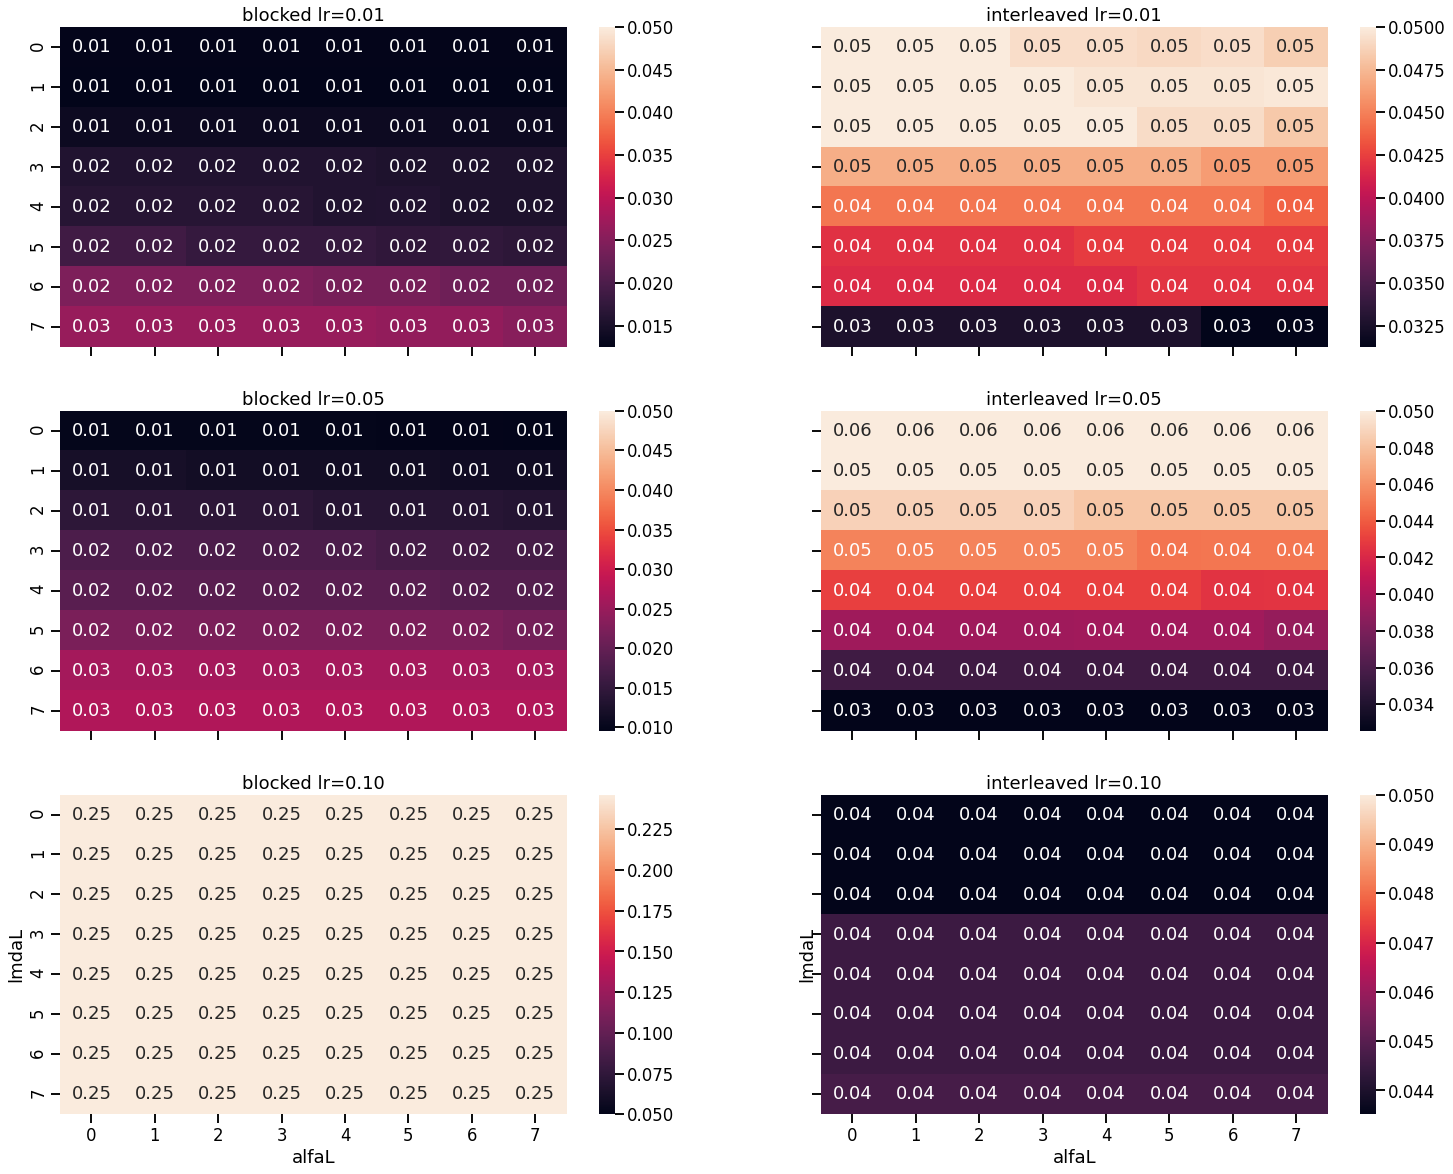

In [106]:
f,axar = plt.subplots(3,2,figsize=(25,20),sharex=True,sharey=True)

for c_i,c in enumerate(['blocked','interleaved']):
  msedf = msedf_[(msedf_.model=='SEM')&(msedf_.cond==c)]
  for lr_i,lr in enumerate(lrL):
    
    ## MAKE ARR
    arr = -np.ones([len(alfaL),len(lmdaL)])
    for a_i,alfa in enumerate(alfaL):
      for lm_i,lmda in enumerate(lmdaL):
        lr_bool = (msedf.lr == lr)
        a_bool = (msedf.alfa == alfa)
        lm_bool = (msedf.lmda == lmda)
        m = msedf[lr_bool&a_bool&lm_bool].mse.values
        if len(m):
          arr[a_i,lm_i]=m

    ## PLOT
    ax = axar[lr_i,c_i]
    ax.set_title('%s lr=%.2f'%(c,lr))
    sns.heatmap(arr,ax=ax,annot=arr.round(2),vmax=0.05)
  ax.set_xlabel('alfaL')
  ax.set_ylabel('lmdaL')

plt.savefig('figures/%s/mseheat'%gsname)

In [ ]:
assert False

# schema inference analysis


In [16]:
currD = build_dataD(gsdf,metric='curriculum',verb=False)
schD = build_dataD(gsdf,metric='active_schema',verb=False)
k_ = list(schD.keys())[0]

In [ ]:
cond = 'blocked'
curr_arr = curr_D[k_][cond]
actsch_arr = actsch_D[k_][cond]

actsch_arr
curr_arr.shape